# Building a Movies Recommendation Engine
“*What movie should I watch this evening?*” 

Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

Two most ubiquitous types of recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, I will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:

* About the MovieLens dataset 
* How to load and process the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model for the MovieLens dataset.
* How to develop a collaborative filtering model for the MovieLens dataset.
* How to evaluate these models based on precision and recall.
* Suggestions to improve the model accuracy.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.

The original data are contained in three files, [movies.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/movies.dat), [ratings.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/ratings.dat) and [users.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/users.dat). To make it easier to work with the data, I used a [script](https://github.com/khanhnamle1994/movielens/blob/master/dat_to_csv.py) to convert the .dat files into [.csv files](https://github.com/khanhnamle1994/movielens/tree/master/csv).

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'ts']
ratings = pd.read_csv('csv/ratings.csv', names=r_cols, encoding='latin-1', low_memory=False)

# Reading users file
u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('csv/users.csv', names=u_cols, encoding='latin-1', low_memory=False)

# Reading movies file
m_cols = ['movie_id', 'title' ,'genres']
movies = pd.read_csv('csv/movies.csv', names=m_cols, encoding='latin-1', low_memory=False)

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [37]:
print(ratings.head())

   user_id  movie_id  rating         ts
0  user_id  movie_id  rating         ts
1        1      1193       5  978300760
2        1       661       3  978302109
3        1       914       3  978301968
4        1      3408       4  978300275


In [38]:
ratings = ratings.iloc[1:]
print(ratings.head())

  user_id movie_id rating         ts
1       1     1193      5  978300760
2       1      661      3  978302109
3       1      914      3  978301968
4       1     3408      4  978300275
5       1     2355      5  978824291


In [39]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 1 to 1000209
Data columns (total 4 columns):
user_id     1000209 non-null object
movie_id    1000209 non-null object
rating      1000209 non-null object
ts          1000209 non-null object
dtypes: object(4)
memory usage: 30.5+ MB
None


This confirms that there are 1M ratings for different user and movie combinations. Also notice that each rating has a timestamp (ts) associated with it.

### Users Dataset

In [11]:
print(users.head())

   user_id  gender  age  occupation    zip
0  user_id  gender  age  occupation    zip
1        1       F    1          10  48067
2        2       M   56          16  70072
3        3       M   25          15  55117
4        4       M   45           7  02460


In [12]:
users = users.iloc[1:]
print(users.head())

  user_id gender age occupation    zip
1       1      F   1         10  48067
2       2      M  56         16  70072
3       3      M  25         15  55117
4       4      M  45          7  02460
5       5      M  25         20  55455


In [13]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 1 to 6040
Data columns (total 5 columns):
user_id       6040 non-null object
gender        6040 non-null object
age           6040 non-null object
occupation    6040 non-null object
zip           6040 non-null object
dtypes: object(5)
memory usage: 236.0+ KB
None


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [27]:
print(movies.head())

   movie_id                     title                        genres
0  movie_id                     title                        genres
1         1          Toy Story (1995)   Animation|Children's|Comedy
2         2            Jumanji (1995)  Adventure|Children's|Fantasy
3         3   Grumpier Old Men (1995)                Comedy|Romance
4         4  Waiting to Exhale (1995)                  Comedy|Drama


In [28]:
movies = movies.iloc[1:]
print(movies.head())

  movie_id                               title                        genres
1        1                    Toy Story (1995)   Animation|Children's|Comedy
2        2                      Jumanji (1995)  Adventure|Children's|Fantasy
3        3             Grumpier Old Men (1995)                Comedy|Romance
4        4            Waiting to Exhale (1995)                  Comedy|Drama
5        5  Father of the Bride Part II (1995)                        Comedy


In [29]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 1 to 3883
Data columns (total 3 columns):
movie_id    3883 non-null object
title       3883 non-null object
genres      3883 non-null object
dtypes: object(3)
memory usage: 91.1+ KB
None


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

In order to work with the data easier, I first remove unuseful features including timestamps, occupation and zip-code. Then I merge the 3 dataframes into a single one, calling it *dataset*. This will be handful for the exploratory data analysis part below.

In [18]:
# Remove the features that are not useful
ratings = ratings.drop(['ts'], axis=1)
users = users.drop(['occupation'], axis=1)
users = users.drop(['zip'], axis=1)

In [19]:
# Create one data frame from the three
dataset = pd.merge(pd.merge(movies, ratings),users)
print(dataset.shape)
print(dataset.head())

(1000209, 7)
  movie_id                                      title  \
0        1                           Toy Story (1995)   
1       48                          Pocahontas (1995)   
2      150                           Apollo 13 (1995)   
3      260  Star Wars: Episode IV - A New Hope (1977)   
4      527                    Schindler's List (1993)   

                                 genres user_id rating gender age  
0           Animation|Children's|Comedy       1      5      F   1  
1  Animation|Children's|Musical|Romance       1      5      F   1  
2                                 Drama       1      5      F   1  
3       Action|Adventure|Fantasy|Sci-Fi       1      4      F   1  
4                             Drama|War       1      5      F   1  


## Data Exploration
### Titles
Are there certain words that feature more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization.

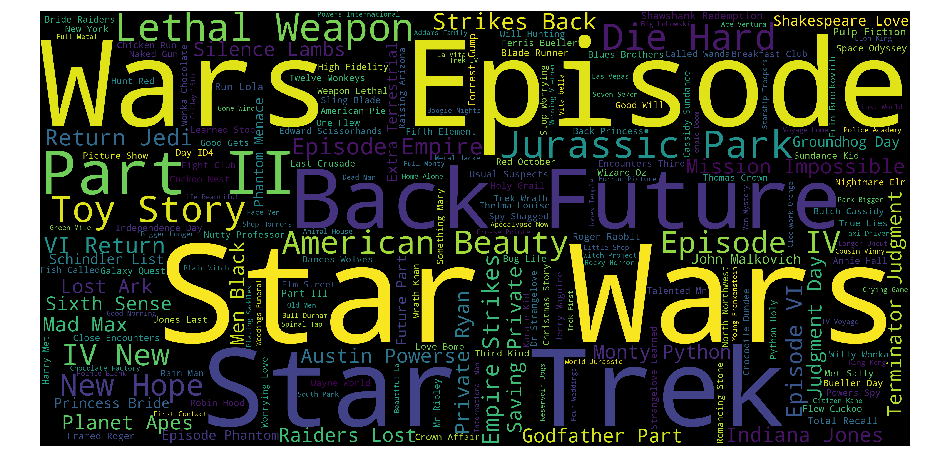

In [13]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
dataset['title'] = dataset['title'].fillna("").astype('str')
title_corpus = ' '.join(dataset['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Beautiful, isn't it? I can recognize that there are a lot of movie franchises in this dataset, such as Mission Impossible, Star Trek, Star Wars, Toy Story, Die Hard, Jurassic Park, Indiana Jones... In addition to that, *Wars*, *Back*, *Future*, *Episode*, *Part II* are mong the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [40]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

# Convert rating into numeric value
dataset['rating'] = dataset['rating'].apply(clean_numeric).astype('float')
# Get summary statistics of rating
dataset['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

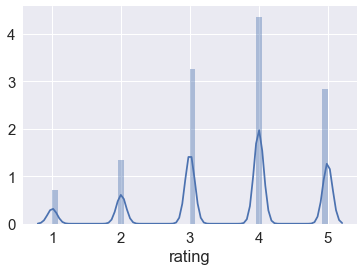

In [41]:
%matplotlib inline
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of rating
sns.distplot(dataset['rating'].fillna(dataset['rating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.59 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

Let's also take a look at a subset of 20 movies with the highest rating.

In [42]:
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5.0
489283,American Beauty (1999),Comedy|Drama,5.0
489259,Election (1999),Comedy,5.0
489257,Matrix` The (1999),Action|Sci-Fi|Thriller,5.0
489256,Dead Ringers (1988),Drama|Thriller,5.0
489237,Rushmore (1998),Comedy,5.0
489236,Simple Plan` A (1998),Crime|Thriller,5.0
489226,Hands on a Hard Body (1996),Documentary,5.0
489224,Pleasantville (1998),Comedy,5.0
489212,Say Anything... (1989),Comedy|Drama|Romance,5.0


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [19]:
# Make a census of the genre keywords
genre_labels = set()
for s in dataset['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(dataset, 'genres', genre_labels)
keyword_occurences[:5]

[['Comedy', 356580],
 ['Drama', 354529],
 ['Action', 257457],
 ['Thriller', 189680],
 ['Sci-Fi', 157294]]

The top 5 genres are, in that respect order: Comedy, Drama, Action, Thriller, and Sci-Fi. I'll show this on a wordcloud too in order to make it more visually appealing.

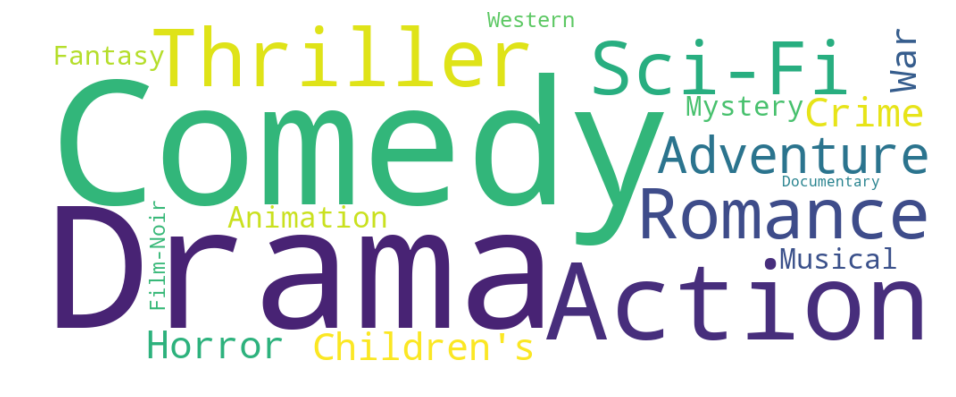

In [20]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

![rec-systems](rec-systems.png)

## Content-Based Recommendation Model
### Theory
The concepts of **Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “**the results of latest European Socccer games**” on Google. It is certain that “**the**” will occur more frequently than “**soccer games**” but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
![tfidf](tfidf.jpg)

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

![vector-space](vector_space.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### Implementation
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie that a user liked. To do so, I will make use of the file **movies.csv**.

In [30]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [32]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.14193614, 0.09010857, ..., 0.        , 0.        ,
       0.        ])

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [33]:
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on their cosine similarity score
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [34]:
get_recommendations('Scream (1996)').head(15)

965       Farewell to Arms` A (1932)
1058           For the Moment (1994)
1378          In Love and War (1996)
2765             Lucie Aubrac (1997)
1085          Days of Thunder (1990)
1086                  Top Gun (1986)
3384           Romeo Must Die (2000)
150                   Rob Roy (1995)
386       Colonel Chabert` Le (1994)
901                Casablanca (1942)
909        Gone with the Wind (1939)
1079         Crying Game` The (1992)
1167     English Patient` The (1996)
1857                    Wings (1927)
1876    From Here to Eternity (1953)
Name: title, dtype: object

**Scream** is one of the best horror movies of all time. The recommendation engine gives me a whole lot of other equally terryifing horror movies, such as **Nightwatch**, **Disturbing Behavior**, and of course **Scream 2**.

In [35]:
get_recommendations('Toy Story (1995)').head(15)

56                         Kids of the Round Table (1995)
60                     Indian in the Cupboard` The (1995)
125                     NeverEnding Story III` The (1994)
997                       Escape to Witch Mountain (1975)
1899                                     Labyrinth (1986)
1937                                  Goonies` The (1985)
1975            Darby O'Gill and the Little People (1959)
2093                        NeverEnding Story` The (1984)
2094    NeverEnding Story II: The Next Chapter` The (1...
2331                        Santa Claus: The Movie (1985)
1490                            Warriors of Virtue (1997)
1543                                Simple Wish` A (1997)
1007                  20`000 Leagues Under the Sea (1954)
1699                                      Star Kid (1997)
2025                                  Return to Oz (1985)
Name: title, dtype: object

**Toy Story** is certainly my favorite film in the animation and children's genres. I think I'd enjoy titles like **A Bug's Life**, **Chicken Run**, and **The Adventures of Rocky and Bullwinkle** as well.

In [36]:
get_recommendations('Saving Private Ryan (1998)').head(15)

7                          Sabrina (1995)
39                        Clueless (1995)
64                   Two if by Sea (1996)
68     French Twist (Gazon maudit) (1995)
92             Vampire in Brooklyn (1995)
117                   If Lucy Fell (1996)
121                      Boomerang (1992)
128                 Pie in the Sky (1995)
234                    French Kiss (1995)
235                   Forget Paris (1995)
250                           I.Q. (1994)
274                     Milk Money (1994)
285             Nina Takes a Lover (1994)
287                       Only You (1994)
292              Perez Family` The (1995)
Name: title, dtype: object

**Saving Private Ryan** is undoubtedly one of the best war, action, drama movies I've ever seen. **G. I. Jane**, ** The Patriot**, **The Thin Red Line** are now on my to-watch list.

### Evaluation

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

![user_item_cf](user_item_cf.jpg)

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the **user-similarity matrix** will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the **item-similarity matrix** will measure the similarity between any two pairs of items.

A common distance metric is the cosine similarity that I used for the content-based recommender in the previous section. Let's try this similarity metric again.

### Implementation
I will use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I do some quick data processing:

In [43]:
# Convert User ID and Movie ID data types from object into numeric value
ratings['user_id'] = ratings['user_id'].fillna(0).astype('float')
ratings['movie_id'] = ratings['movie_id'].fillna(0).astype('float')

# Convert rating into numeric value
ratings['rating'] = ratings['rating'].apply(clean_numeric).astype('float')
# Replace NaN values with average of columns
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

Now I use the **scikit-learn library** to split the dataset into testing and training.  **Cross_validation.train_test_split** shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [44]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(ratings, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now I create a user-item matrix which I build from the ratings dataset. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [45]:
# Create two user-item matrices, one for training and another for testing
train_data = train_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
test_data = test_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])

In [47]:
# Check their shape
print(train_data.shape)
print(test_data.shape)

(800167, 3)
(200042, 3)


Now I use the **pairwise_distances** function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data, metric='cosine')
item_similarity = pairwise_distances(train_data.T, metric='cosine')

user_similarity[0]
item_similarity[0]

## Suggestions to Improve Model Accuracy

## Summary
**Content-Based Recommendation**:
* The major advantage on content based approach is its ability to recommend previously unrated item to users. Unlike collaborating filtering, content based approach are able to effectively recommend unrated items and provide quality recommendation to users with unique taste.
* The main disadvantage of this approach is each item in the entire system must have a precise description such that the system can recommend accurately. And also, they are not capable of filtering items on some assessment of quality, style or viewpoint because of lack of consideration of other people’s experience. Content based approach can’t recommend serendipitous items. That means user are generally recommended items of that are similar in context. The other disadvantage with such system is the problem of synonymy. There are many different keywords having same meaning, they are treated as independent words by content filtering approach such that no similarity can be obtained in user’s profile and item profile.